# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an machine learning project to use the characteristics of bulldozers and their past sales prices to predict the sale price of future bulldozers based on their characteristics.

## 1. Problem Definition
How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for ?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers Competition : https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets :

* `Train.csv` - is the training set, which contains data through the end of 2011.
* `Valid.csv` - is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* `Test.csv` - is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this competition is the root mean squared log error (RMSLE) between the actual and predicted auction prices.

For more on the evaluation of this project check :
www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all of the features of the dataset. We can view this data dictionary on Google Sheets: 
https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [31]:
# Import the training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory = False)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [33]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

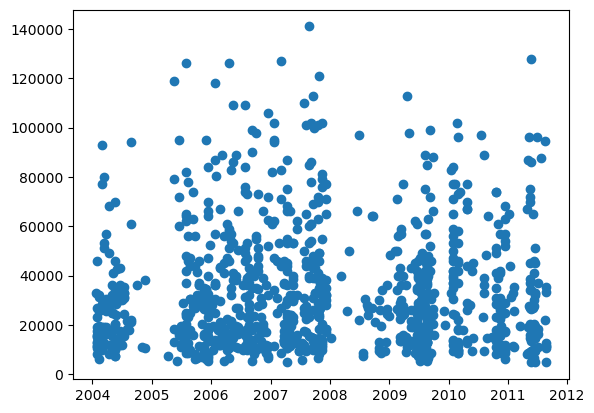

In [42]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [41]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

<Axes: ylabel='Frequency'>

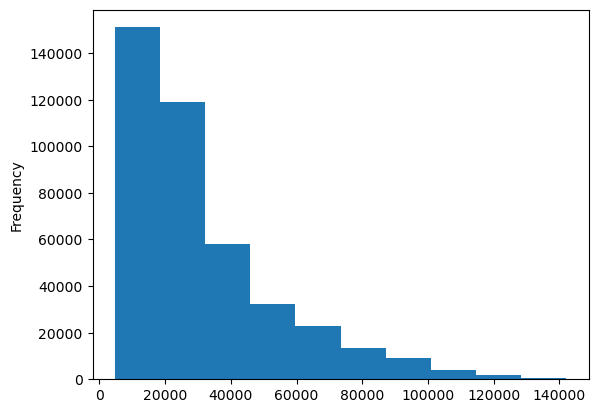

In [39]:
df.SalePrice.plot.hist()

### Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [38]:
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory = False,
                parse_dates = ["saledate"])

In [6]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

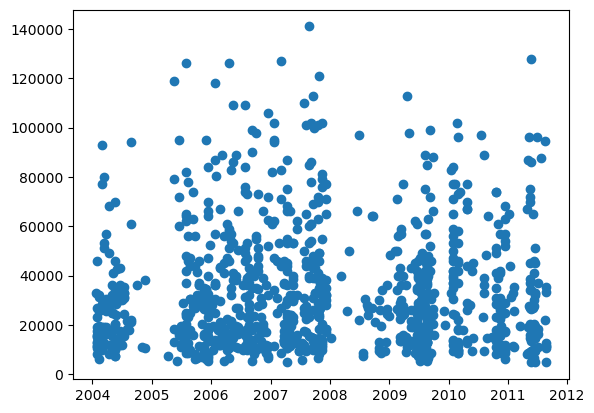

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [33]:
df.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246    66000.0     999089     3157         121           3.0      2004   
1  1139248    57000.0     117657       77         121           3.0      1996   
2  1139249    10000.0     434808     7009         121           3.0      2001   
3  1139251    38500.0    1026470      332         121           3.0      2001   
4  1139253    11000.0    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand   saledate  ... Undercarriage_Pad_Width  \
0                      68.0       Low 2006-11-16  ...                     NaN   
1                    4640.0       Low 2004-03-26  ...                     NaN   
2                    2838.0      High 2004-02-26  ...                     NaN   
3                    3486.0      High 2011-05-19  ...                     NaN   
4                     722.0    Medium 2009-07-23  ...                     NaN   

  Stick_Length Thumb Pattern_Changer Grouser_Type Backhoe_Mounting Blade_Type  \
0          NaN   NaN             NaN          NaN              NaN        NaN   
1          NaN   NaN             NaN          NaN              NaN        NaN   
2          NaN   NaN             NaN          NaN              NaN        NaN   
3          NaN   NaN             NaN          NaN              NaN        NaN   
4          NaN   NaN             NaN          NaN              NaN        NaN   

  Travel_Controls Differential_Type Steering_Controls  
0             NaN          Standard      Conventional  
1             NaN          Standard      Conventional  
2             NaN               NaN               NaN  
3             NaN               NaN               NaN  
4             NaN               NaN               NaN  

[5 rows x 53 columns]

In [34]:
df.head().T

0  \
SalesID                                                    1139246   
SalePrice                                                  66000.0   
MachineID                                                   999089   
ModelID                                                       3157   
datasource                                                     121   
auctioneerID                                                   3.0   
YearMade                                                      2004   
MachineHoursCurrentMeter                                      68.0   
UsageBand                                                      Low   
saledate                                       2006-11-16 00:00:00   
fiModelDesc                                                   521D   
fiBaseModel                                                    521   
fiSecondaryDesc                                                  D   
fiModelSeries                                                  NaN   
fiModelDescriptor                                              NaN   
ProductSize                                                    NaN   
fiProductClassDesc        Wheel Loader - 110.0 to 120.0 Horsepower   
state                                                      Alabama   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                          None or Unspecified   
Pad_Type                                                       NaN   
Ride_Control                                   None or Unspecified   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                      None or Unspecified   
Coupler                                        None or Unspecified   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                                 1  \
SalesID                                                    1139248   
SalePrice                                                  57000.0   
MachineID                                                   117657   
Mode

In [37]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate
When working with time series data, it's a good idea to sort it by date.

In [44]:
df.sort_values(by = ["saledate"],
               inplace = True,
               ascending = True)

In [45]:
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original Dataframe
We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [46]:
# Make a copy
df_tmp = df.copy()

In [47]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [42]:
df_tmp.head().T

205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
saledate                                                1989-01-17 00:00:00   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                         

### Add datetime parameters for `saledate` column

In [48]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [49]:
df_tmp.head().T

205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
saledate                                                1989-01-17 00:00:00   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                         

In [50]:
df_tmp.tail().T

410879  \
SalesID                                                             6302984   
SalePrice                                                           16000.0   
MachineID                                                           1915521   
ModelID                                                                5266   
datasource                                                              149   
auctioneerID                                                           99.0   
YearMade                                                               2001   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
saledate                                                2012-04-28 00:00:00   
fiModelDesc                                                            D38E   
fiBaseModel                                                             D38   
fiSecondaryDesc                                                           E   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                             NaN   
fiProductClassDesc        Track Type Tractor, Dozer - 75.0 to 85.0 Horse...   
state                                                            California   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                       Standard   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                          Multi Shank   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                              PAT   
Travel_Controls                         

In [16]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int32

In [17]:
df_tmp[:1].saledate.dt.date

205615    1989-01-17
Name: saledate, dtype: object

In [22]:
# Drop original saledate column
df_tmp.drop("saledate", axis = 1, inplace = True)

In [51]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

# Modelling

In [56]:
# Let's build a Machine Learning Model
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
model = RandomForestRegressor(n_jobs = -1, random_state = 42)

# Split into X and y datasets
X = df_tmp.drop("SalePrice", axis = 1)
y = df_tmp["SalePrice"]

# model.fit(X)

In [57]:
df_tmp["UsageBand"].dtype

dtype('O')

## Convert string/object to categories

One way we can turn all of our data into numbers is by converting them into pandas categories

We can check the different data types compatible with pandas here :
https://pandas.pydata.org/pandas-docs/version/1.4/reference/general_utility_functions.html

In [60]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [94]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
saledate
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [85]:
# Turning all the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [86]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   saledate                  412698 non-null  category
 10  fiModelDesc               412698 non-null  category
 11  fiBaseModel               412698 non-null  category
 12  fiSecondaryDesc           271971 non-null  category
 13  fiModelSeries             586

In [69]:
df_tmp["UsageBand"].dtype

CategoricalDtype(categories=['High', 'Low', 'Medium'], ordered=True, categories_dtype=object)

In [70]:
df_tmp["state"].dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=True, categories_dtype=object)

In [71]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

### Save preprocessed data

In [74]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", index = False)

In [75]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv", low_memory = False)
df_tmp.head().T

0  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
saledate                                                         1989-01-17   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                              

In [88]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [89]:
df_tmp.state.cat.codes

0         43
1          8
2          8
3          8
4          8
          ..
412693     4
412694     4
412695     4
412696     4
412697     4
Length: 412698, dtype: int8

In [90]:
df_tmp.state.dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=True, categories_dtype=object)